# The simplest case of the ratio estimator
### The easiest example to run if the physically meaningful $R$ is directly the ratio of two data sets, but not there underlying model. 

### Meanwhile, the measurement errors in ${\bf d}_1, {\bf d}_2$ are uncorrelated. 

### We can choose the mapping matrix ${\bf A}_1 = {\bf I}, {\bf A}_2 = R{\bf I}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
from matplotlib.ticker import AutoMinorLocator
fontsize=22
matplotlib.rcParams.update({'font.size':fontsize})

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [2]:
N_d = 10  # number of data points

def generate_data_sets(N_d):
    '''
    Generate two Gaussian data sets.
    '''
    d1 = np.random.normal(loc = 1, scale = 0.2, size=N_d) # d1, d2 are Gaussian distributed
    d2 = np.random.normal(loc = 2, scale = 0.3, size=N_d)

    n1 = np.random.rand(N_d)*0.4  # random fractional error
    n2 = np.random.rand(N_d)*0.3
    cov1 = np.diag(n1**2)  # here do not consider the off-diagnal terms,
    cov2 = np.diag(n2**2)  # this method also works for the full covariance matrix, 
                           # e.g. d1 errors are correlated
    return d1, d2, n1, n2, cov1, cov2
d1, d2, n1, n2, cov1, cov2 = generate_data_sets(N_d)

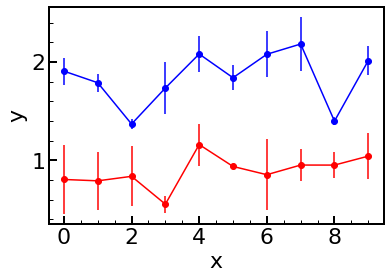

In [3]:
def plot_data_sets(N_d, d1, d2, n1, n2):
    plt.errorbar(np.arange(N_d), d1, n1, c = 'r', marker='o', label='d1')
    plt.errorbar(np.arange(N_d), d2, n2, c = 'b', marker='o', label='d2')
    plt.xlabel('x')
    plt.ylabel('y')
    ax = plt.gca()
    xminorLocator = AutoMinorLocator()
    yminorLocator = AutoMinorLocator()
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.tick_params(labelsize=fontsize)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(axis='x',which='major',size=8,width=2)
    ax.tick_params(axis='y',which='major',size=8,width=2)
    ax.tick_params(axis='x',which='minor',size=4,width=1)
    ax.tick_params(axis='y',which='minor',size=4,width=1)
plot_data_sets(N_d, d1, d2, n1, n2)

In [4]:
def unbiased_R_estimator(d1,d2,cov1,cov2):
    deltaR=0.001 
    R = np.arange(1,3,deltaR) # try various R
    NR = len(R)
    
    def Matrix3(M1,M2,M3): # Multiplication of three matrices
        return np.dot(np.dot(M1,M2),M3)

    def prob_R(d1,d2,cov1,cov2,R):
        from numpy.linalg import inv
        n = d1.shape[0]
        a1 = np.identity(n) # the mapping matrix A1, A2 is indentity
        a2 = a1 * R         # Eq.19 in paper
        q1 = Matrix3(a1.T, inv(cov1), a1)  
        q2 = Matrix3(a2.T, inv(cov2), a2)
        q = q1 + q2  # defination is below Eq.5
        d1 = d1.reshape(1,n)
        d2 = d2.reshape(1,n)
        t1 = Matrix3(a1.T, inv(cov1), d1.T)
        t2 = Matrix3(a2.T, inv(cov2), d2.T)
        t = t1 + t2  # defination is below Eq.5
        return 0.5 * Matrix3(t.T, inv(q), t), np.sqrt(np.linalg.det(q)) # two terms in Eq.8

    def pdf(d1,d2,cov1,cov2,R):
        Exp_index=[]; DetQ=[]
        for rr in range(NR):
            exp_index, detQ = prob_R(d1=d1,d2=d2,cov1=cov1,cov2=cov2,R=R[rr])
            Exp_index.append(exp_index)
            DetQ.append(detQ)
        Exp_index = np.array(Exp_index).reshape(NR)
        index_max = max(Exp_index)

        # To avoid numerical errors associated with too large/small exponential terms,
        # a safer way is to evaluate the r.h.s of Eq.10 as a function of R,
        # find the maximum, and then subtract this maximum before evaluating P(R).
        PROB = np.exp(Exp_index - index_max) * DetQ
        y = PROB/PROB.max() / R # Jefferys 1/R prior
        area = deltaR * np.sum(y)
        y_norm = y / area   # PDF normalization
        max_index = np.argmax(y_norm)
        R_mean = R[max_index]  # find the bestfit R, which means PDF reaches the maximum
        return max_index, R_mean, y_norm

    def pdf_1sigma(max_index, R_mean, y_norm):
        # find the lower limit of R, which requires the integral area is 0.34 (1-sigma)
        f = np.ones(max_index)
        for x in range(0,max_index):
            f[x] = abs(0.34 / deltaR - np.sum(y_norm[x:max_index])) 
        x1 = np.argmin(f)  # the index of lower limit R

        # find the upper limit of R, which requires the integral area is 0.34 (1-sigma)
        v = np.ones(NR - max_index)
        for u in range(max_index,NR):
            v[u-max_index] = abs(0.34 / deltaR - np.sum(y_norm[max_index:u]))
        x2 = max_index + np.argmin(v) # the index of upper limit R

        delta_x1 = R[max_index] - R[x1]
        delta_x2 = R[x2] - R[max_index]
        return x1, x2, delta_x1, delta_x2
    
    def gaussian_func(mu,sigma):
        gau = 1./np.sqrt(2*np.pi) * np.exp(-(R-mu)**2 / 2./sigma**2)
        return gau
    
    max_index, R_mean, y_norm = pdf(d1,d2,cov1,cov2,R)
    x1, x2, delta_x1, delta_x2 = pdf_1sigma(max_index, R_mean, y_norm)
    
    delta_x = (delta_x1 + delta_x2) / 2
    gau = gaussian_func(R_mean, delta_x)
    sum_gau = np.sum(gau)*deltaR
    gau_norm = gau / sum_gau
    
    return R, R_mean, y_norm, x1, x2, max_index, delta_x1, delta_x2, gau_norm

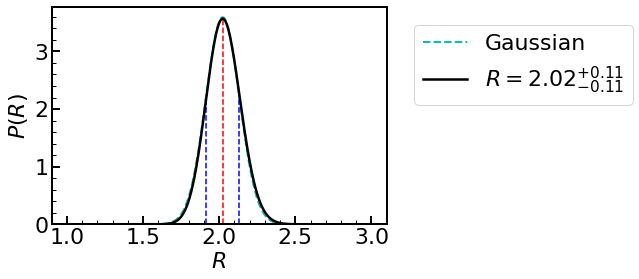

In [5]:
def plot_pdf():
    R, R_mean, y_norm, x1, x2, max_index, delta_x1, delta_x2, gau_norm = unbiased_R_estimator(d1,d2,cov1,cov2)
    plt.plot(R,gau_norm,'c--',lw=2, label='Gaussian')
    
    plt.plot(R,y_norm,'k', lw=2.5, label='$R = %1.2f^{+%.2f}_{-%.2f}$'%(R_mean, delta_x2, delta_x1))
    plt.vlines(R_mean, 0, y_norm[max_index], color='r',ls='--')
    plt.vlines(R[x1], 0, y_norm[x1], color='b',ls='--')
    plt.vlines(R[x2], 0, y_norm[x2], color='b',ls='--')
    
    ax = plt.gca()
    xminorLocator = AutoMinorLocator()
    yminorLocator = AutoMinorLocator()
    ax.xaxis.set_minor_locator(xminorLocator)
    ax.yaxis.set_minor_locator(yminorLocator)
    ax.tick_params(labelsize=fontsize)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.tick_params(axis='x',which='major',size=8,width=2)
    ax.tick_params(axis='y',which='major',size=8,width=2)
    ax.tick_params(axis='x',which='minor',size=4,width=1)
    ax.tick_params(axis='y',which='minor',size=4,width=1)
    plt.xlabel('$R$')
    plt.ylabel('$P(R)$')
    plt.ylim(0)
    plt.legend(fontsize=fontsize, bbox_to_anchor=(1.05, 0.5), loc=3)
plot_pdf()